In [1]:
import sys
sys.path.append("NeCo/scripts/")

import numpy as np
import scipy as sp
from scipy import special
from scipy import signal
import scipy.stats as st
import matplotlib.pyplot as plt
import bayesianTunLib as btl
% matplotlib inline

## Prior and Cumulative Prior

$$ \forall s \in [s_m, s_M], \quad d(s) = \frac{1}{\tau}\exp{\left(-\frac{s}{\tau}\right) } + \frac{g}{\sqrt{2\pi}\sigma}\exp{ \left(- \frac{(s-\mu)^2}{2\sigma^2} \right) } $$

$$ D(s) = s_m + \frac{s_M-s_m}{Z}\int_{s_m}^{s} d(u) \mathrm{d}u$$
where $Z = \int d(u) \mathrm{d}u.$

## Tuning curve template

$$ f(s;\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp{ \left(- \frac{(s-\mu)^2}{2\sigma^2} \right) } $$

In [2]:
spMin = -0.0
spMax = 200.0

d = lambda s,tau,g,mu,sig: (np.exp(-s/tau)/tau +\
        g*np.exp(-(s-mu)**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2))/(1.0+g)
#+s.min()#s.max()*

D = lambda s,tau,g,mu,sig: spMax*((1.0-np.exp(-s/tau))+ g*btl.Psi(s,mu,sig))/(1.0+g)+spMin


# template tuning curve
gauss = lambda s,mu,sig: np.exp(-(s-mu)**2/(2*sig**2))/np.sqrt(2*np.pi*sig**2)

# window to fit [sm,sM]
winA = lambda s,sm,alpha : 0.5 * (1.0 + np.cos(np.pi * (-sm/(alpha)+1.0*s/alpha)))\
        *(s<sm+alpha)*(s>sm) + 1.0*(s<=sm)
winB = lambda s,sm,alpha: 0.5 * (1.0 + np.cos(np.pi * (1.0 - sm/(alpha)+1.0*s/alpha)))\
        *(s<sm+alpha)*(s>sm) + 1.0*(s>=sm+alpha) 

## Tuning curves

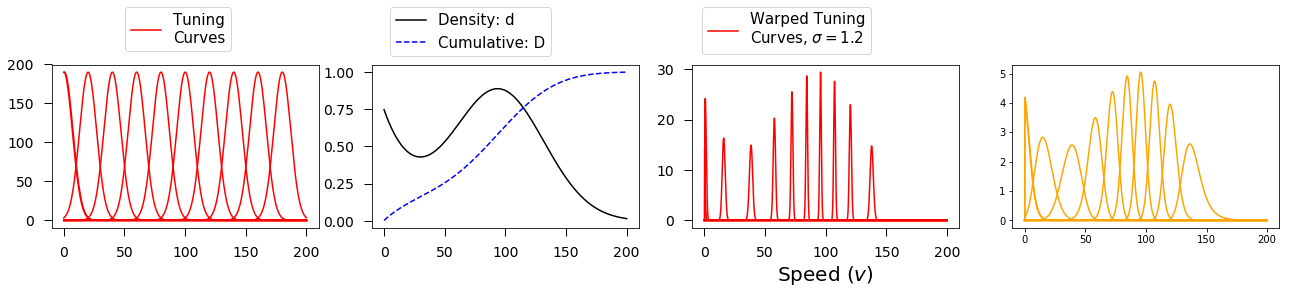

In [31]:
# feature space
N = 4000
speed = np.linspace(spMin,spMax,N)

# param prior
tau = 28.0
g = 4.0
mu = 95.0
sig = 37.0

# speed pref of each neuron
speedPref = np.linspace(spMin, spMax, 2000)

# tuning curve bandwidth
sigTun0 = 1.2
sigTun1 = 7.0

# warped tuning curve
tunCurve0 = lambda s: gauss(D(s,tau,g,mu,sig),speedPref[np.newaxis,:],sigTun0)*d(s,tau,g,mu,sig)\
                        *winA(s,190,1)*winB(s,0.2,0.1)#
tunCurve1 = lambda s: gauss(D(s,tau,g,mu,sig),speedPref[np.newaxis,:],sigTun1)*d(s,tau,g,mu,sig)\
                        *winA(s,190,1)*winB(s,0.2,0.1)#
tunCurve = lambda s: gauss(s,speedPref[np.newaxis,:],sigTun1)#*winA(s,190,1)*winB(s,0.2,0.1)

fig02, axes02 = plt.subplots(nrows=1, ncols=4, figsize=(22, 3))

axes02[0].plot(speed,10000*tunCurve(speed[:,np.newaxis])[:,5]/3.0, c='r',\
              label='Tuning\nCurves');
axes02[0].plot(speed,10000*tunCurve(speed[:,np.newaxis])[:,::200]/3.0, c='r');

axes02[1].plot(speed,100*d(speed,tau,g,mu,sig),c='k', label='Density: d')
axes02[1].plot(speed,D(speed,tau,g,mu,sig)/200.0,ls='--',c='b', label='Cumulative: D')
    
axes02[2].plot(speed,10000*tunCurve0(speed[:,np.newaxis])[:,20]/1.0, c='r',\
              label='Warped Tuning\nCurves, $\sigma=1.2$');
axes02[3].plot(speed,10000*tunCurve1(speed[:,np.newaxis])[:,5], c='orange',\
              label='Warped Tuning\nCurves, $\sigma=7.0$');
axes02[2].plot(speed,10000*tunCurve0(speed[:,np.newaxis])[:,::200]/1.0, c='r');
axes02[3].plot(speed,10000*tunCurve1(speed[:,np.newaxis])[:,::200], c='orange');

axes02[2].set_xlabel('Speed ($v$)', fontsize=20.0)

for i in range(3):
    axes02[i].legend(bbox_to_anchor=(0.5, 1.2, 0.2, 0.2), fontsize = 15)
    axes02[i].tick_params(axis='both', which='major', labelsize=14, pad=10, length=8, width=1)

In [36]:
# fig02.savefig('tunCurvesBand.pdf', format='pdf', bbox_inches='tight')

## Likelihood

Let $s_0$ be the stimulus, then the likelihood is
$$ L(s) = f(s_0; s,\sigma) $$
$\textit{ie}$ each neuron with prefered stimulus $s$ and bandwidth $\sigma$ responds to $s_0$.

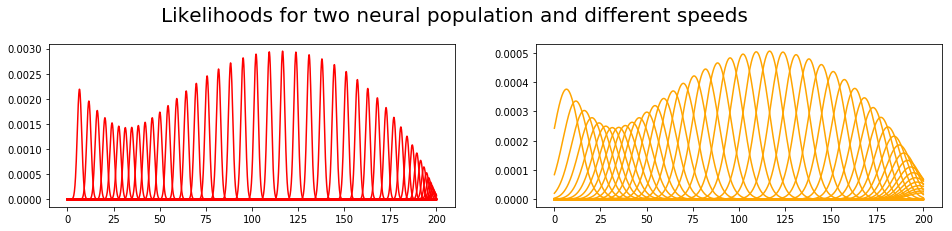

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))

spTest = np.array(np.linspace(0.0,200,99))

k=0
for spe in spTest:
    if np.mod(k,2)==0:
        if k==0:
            ax[0].plot(speedPref, 1.0*tunCurve0(np.array(spe))[0,:]\
                           , c='r', label='Warped Tuning\nCurves, $\sigma=1.2$')
            ax[1].plot(speedPref, 1.0*tunCurve1(np.array(spe))[0,:],\
                        c='orange', label='Warped Tuning\nCurves, $\sigma=7.0$') 
        else:
            ax[0].plot(speedPref, 1.0*tunCurve0(np.array(spe))[0,:], c='r') 
            ax[1].plot(speedPref, 1.0*tunCurve1(np.array(spe))[0,:], c='orange') 
    k+=1

ax[0].set_title('Likelihoods for two neural population and different speeds', fontsize=20, x=1.0, y=1.1);

## Speed estimation

### MAP Estimator 

$$ \hat s = \mathrm{argmax}_s L(s) $$ 

### MSE Estimator 

$$ \hat s = \frac{\int_{s_m}^{s_M} s L(s) \mathrm{d}s}{\int_{s_m}^{s_M} L(s) \mathrm{d}s}  $$ 


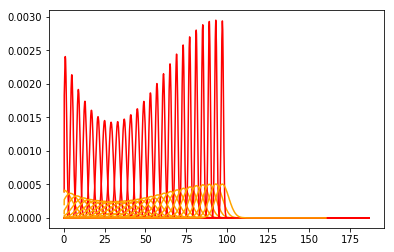

In [38]:
# Here we use the MAP estimator

speedPref0 = speed[np.argmax(tunCurve0(speed[:,np.newaxis])[:,:],axis=0)]
speedPref1 = speed[np.argmax(tunCurve1(speed[:,np.newaxis])[:,:],axis=0)]

estim0 = np.zeros(100)
estim1 = np.zeros(100)

spTest = np.array(np.linspace(1,100,100))

k=0
for spe in spTest:
    if np.mod(k,4)==0:
        plt.plot(speedPref0, tunCurve0(np.array(spe))[0,:], c='r')
        plt.plot(speedPref1, tunCurve1(np.array(spe))[0,:], c='orange')
    # MAP estim
    estim0[k] = speedPref0[tunCurve0(np.array(spe))[0,:].argmax()]
    estim1[k] = speedPref1[tunCurve1(np.array(spe))[0,:].argmax()]
    k+=1

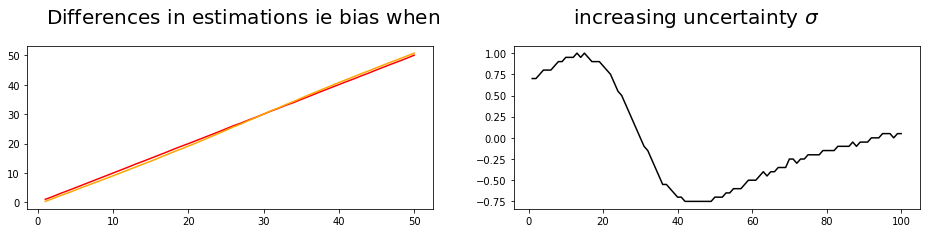

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))

ax[0].plot(spTest[:50],estim0[:50], c='r')
ax[0].plot(spTest[:50],estim1[:50], c='orange')
ax[1].plot(spTest,estim0-estim1, c='k');
ax[0].set_title('Differences in estimations ie bias when \
                    increasing uncertainty $\sigma$',fontsize=20,x=1.0, y=1.1);

# Simulation 2AFC psychophysics experiment

There is one reference stimulus (spRef) that we test against higher or lower valued stimuli (spTestExp).

Estimation of the presented stimulus are performed with the two above neural populations.

In [40]:
# simulate neural activity from tuning curves
spRef = 12
if spRef==5:
    spTestExp = np.linspace(2,8,21)
elif spRef==12:
    spTestExp = np.linspace(9,15,21)
elif spRef==20:
    spTestExp = np.linspace(17,23,21)

Rep = 50

std0 = 1.0
mult = 15.0
nTime = 200


sigTunTest = np.array([1.2]) #5.0np.array([3.0,4.0,5.0,6.0,7.0])

speedRefEstim0 = np.zeros((sigTunTest.shape[0],Rep,spTestExp.shape[0]))
speedRefEstim1 = np.zeros((sigTunTest.shape[0],Rep,spTestExp.shape[0]))
speedTestEstim0 = np.zeros((sigTunTest.shape[0],Rep,spTestExp.shape[0]))
speedTestEstim1 = np.zeros((sigTunTest.shape[0],Rep,spTestExp.shape[0]))

l = 0
for sigTun in sigTunTest:
    tunCurve1 = lambda s : 0.05*gauss(D(s,tau,g,mu,sig),\
       speedPref[np.newaxis,:],sigTun)*d(s,tau,g,mu,sig)
    speedPref1 = speed[np.argmax(tunCurve1(speed[:,np.newaxis])[:,:],axis=0)]
    
    for i in range(Rep):
        k = 0
        for sp in spTestExp:
            
            empiricalWarpedTunRef0 = np.mean(np.random.poisson(np.repeat(mult*\
                                    tunCurve0(np.array(spRef)),\
                                    nTime, axis=0)), axis=0)  
            #/tunCurve0(np.array(spRef)).sum()
            speedRefEstim0[l,i,k] = speedPref0[empiricalWarpedTunRef0.argmax()]#+st0*np.random.randn(1)+

            empiricalWarpedTunRef1 = np.mean(np.random.poisson(np.repeat(mult*\
                                    tunCurve1(np.array(spRef)),\
                                    nTime, axis=0)), axis=0)
            #/tunCurve1(np.array(spRef)).sum()
            speedRefEstim1[l,i,k] = speedPref1[empiricalWarpedTunRef1.argmax()]#+st0*np.random.randn(1)+
 
            empiricalWarpedTun0 = np.mean(np.random.poisson(np.repeat(mult*\
                                    tunCurve0(np.array(sp)),\
                                    nTime, axis=0)), axis=0)
            #/tunCurve0(np.array(sp)).sum()
            speedTestEstim0[l,i,k] = speedPref0[empiricalWarpedTun0.argmax()]#+std0*np.random.randn(1)
            
            empiricalWarpedTun1 = np.mean(np.random.poisson(np.repeat(mult*\
                                    tunCurve1(np.array(sp)),\
                                    nTime, axis=0)), axis=0)
            #/tunCurve1(np.array(sp)).sum()
            speedTestEstim1[l,i,k] = speedPref1[empiricalWarpedTun1.argmax()]#+std0*np.random.randn(1)

            k+=1
    l+=1
    print(l)
    
print(k)

1
21


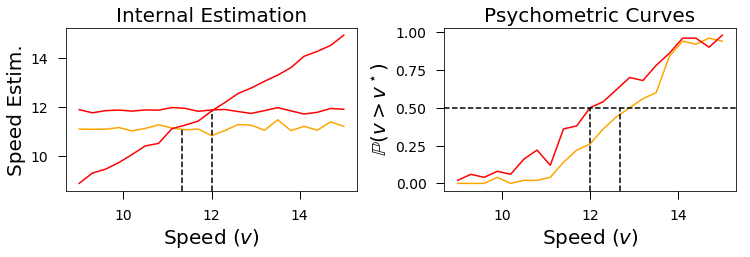

In [41]:
fig02, axes02 = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
fig02.subplots_adjust(wspace=0.3, hspace=0.0)

# 50 repet 200ms stim

for i in range(sigTunTest.shape[0]):
    axes02[0].plot(spTestExp,speedRefEstim0.mean(axis=1)[i,:], c='r')
    axes02[0].plot(spTestExp,speedRefEstim1.mean(axis=1)[i,:], c='orange')
    axes02[0].plot(spTestExp,speedTestEstim0.mean(axis=1)[i,:], c='r')
    #axes02[0].plot(spTestExp,speedTestEstim1.mean(axis=1)[i,:], c='orange')
    
    axes02[1].plot(spTestExp,np.mean(np.float32(speedTestEstim1>speedRefEstim0),axis=1)[i,:], c='orange')
    axes02[1].plot(spTestExp,np.mean(np.float32(speedTestEstim1>speedRefEstim1),axis=1)[i,:], c='r')

axes02[0].axvline(12.0, ymin=0.0, ymax=0.49, ls='--', color='k')
axes02[0].axvline(11.32, ymin=0.0, ymax=0.38, ls='--', color='k')
#axes02[0].legend(bbox_to_anchor=(0.0, 1.02, 0.2, 0.2), fontsize = 15)
axes02[0].set_xlabel('Speed ($v$)', fontsize=20.0)
axes02[0].set_ylabel('Speed Estim.', fontsize=20.0)
axes02[0].tick_params(axis='both', which='major', labelsize=14, pad=10, length=8, width=1)
axes02[0].set_title('Internal Estimation', fontsize=20.0)


axes02[1].axhline(0.5, ls='--', color='k')
axes02[1].axvline(12.0, ymin=0.0, ymax=0.51, ls='--', color='k')
axes02[1].axvline(12.68, ymin=0.0, ymax=0.51, ls='--', color='k')
#axes02[1].legend(bbox_to_anchor=(0.0, 1.02, 0.2, 0.2), fontsize = 15)
axes02[1].set_xlabel('Speed ($v$)', fontsize=20.0)
axes02[1].set_ylabel(r'$\mathbb{P}(v>v^\star)$', fontsize=20.0)
axes02[1].tick_params(axis='both', which='major', labelsize=14, pad=10, length=8, width=1)
axes02[1].set_title('Psychometric Curves', fontsize=20.0);



In [42]:
# fig02.savefig('internEstimPsychCurves.pdf', format='pdf', bbox_inches='tight')

# Wei & Stocker 
http://www.pnas.org/content/114/38/10244.full

$$\mathrm{bias}(s) \propto (\frac{1}{\mathrm{prior}(s)^2})'$$

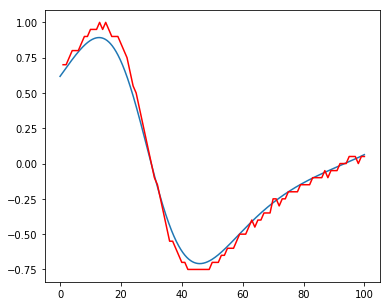

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(speed[:-2000],np.diff(0.011/d(speed[:-1999],tau,g,mu,sig)**2))
ax.plot(spTest,estim0-estim1, c='r')


In [44]:
# np.random.poisson(1,100)

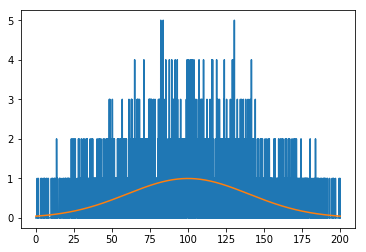

In [45]:
plt.plot(speed,np.random.poisson(100*gauss(speed,100,40)))
plt.plot(speed,100*gauss(speed,100,40))

In [326]:
gauss_poisson = np.random.poisson(1000*gauss(speed,100,150),size=(10000,4000))

In [327]:
gauss_poisson.argmax(axis=1).shape

(10000,)

In [328]:
# argmax_gauss_poisson = speed[gauss_poisson.argmax(axis=1)]
argmax_gauss_poisson = np.sum(gauss_poisson*speed, axis=1)/np.sum(gauss_poisson,axis=1)

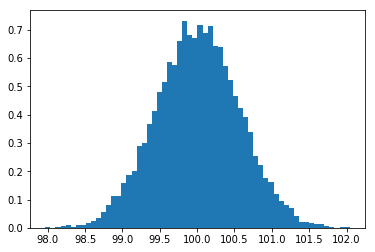

In [329]:
hist = plt.hist(argmax_gauss_poisson, bins=60, density=True);

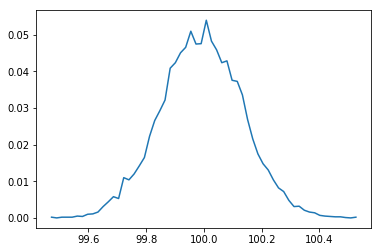

In [261]:
# plt.plot(speed,gauss(speed,100,20))
histo = hist[0]*np.diff(hist[1])[0]
plt.plot(hist[1][:-1],histo)

In [48]:
Y,X = np.mgrid[-128:128,-128:128]

In [78]:
gabor = lambda x,y,s,th,f: np.exp(-(x**2+y**2)/(2*s**2))*np.cos(2*np.pi*f*(np.cos(th)*x+np.sin(th)*y))

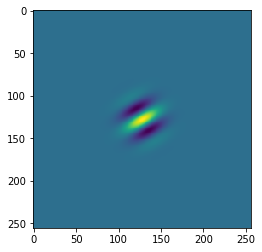

In [211]:
plt.imshow(gabor(X,Y,15,np.pi/3,0.03))

In [86]:
dg = lambda x,y,th,f: np.cos(2*np.pi*f*(np.cos(th)*x+np.sin(th)*y))

In [217]:
sim = lambda a,b,s: np.exp(s*np.dot(a,b)/np.sqrt(np.dot(a,a)*np.dot(b,b)))#np.exp()-1

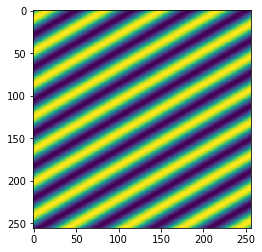

In [218]:
plt.imshow(dg(X,Y,np.pi/3,0.03));

In [229]:
TH = np.linspace(0,np.pi,24)
F = np.logspace(-2,-0.5,24)

gab = gabor(X,Y,15,np.pi/3,0.03).ravel()
res = np.zeros((8,24,24))

i = 0
for s in np.array([1,3,6,9,12,15,18,21]):
    j = 0
    for th in TH:
        k = 0
        for f in F:
            res[i,j,k]=sim(dg(X,Y,th,f).ravel(),gab, s)
            k+=1
        j+=1
    i+=1

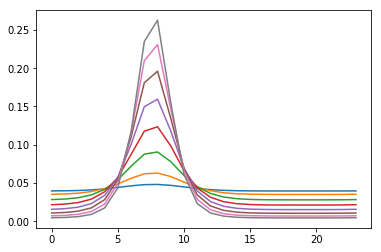

In [233]:
plt.plot(res[:,:,8].T/np.sum(res[:,:,8].T,axis=0, keepdims=True));

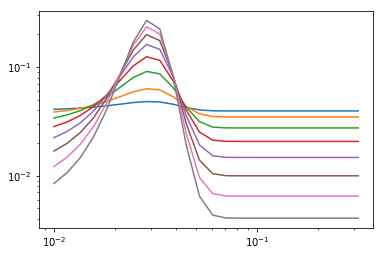

In [238]:
plt.plot(F,res[:,7].T/np.sum(res[:,7].T,axis=0, keepdims=True));
plt.xscale('log')
plt.yscale('log')

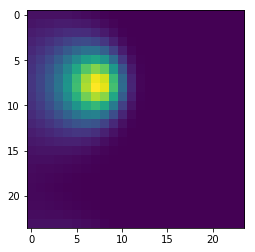

In [236]:
plt.imshow(res[0])

UsageError: Line magic function `%disp` not found.
